In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
from pixell import reproject
from classy import Class
%matplotlib inline
import s1 
import pysm3 
import ST

In [2]:
nside_2048 = 2048
nside_1024 = 1024
nside_0256 = 256

In [3]:
lmax_0256 = 3*nside_0256 -1 
lmax_1024 = 3*nside_1024 -1 
lmax_2048 = 3*nside_2048 -1 

In [4]:
ell_0256 = np.arange(0,lmax_0256+1)
ellsc_0256 = 21600/ell_0256
norm_0256 = ell_0256 * (ell_0256+1) / (2*np.pi)

<ipython-input-4-021124972f74>:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc_0256 = 21600/ell_0256


In [5]:
ell_1024 = np.arange(0,lmax_1024+1)
ellsc_1024 = 21600/ell_1024
norm_1024 = ell_1024 * (ell_1024+1) / (2*np.pi)

<ipython-input-5-d05932342f46>:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc_1024 = 21600/ell_1024


In [6]:
ell_2048 = np.arange(0,lmax_2048+1)
ellsc_2048 = 21600/ell_2048
norm_2048 = ell_2048 * (ell_2048+1) / (2*np.pi)

<ipython-input-6-3509b796c297>:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc_2048 = 21600/ell_2048


In [7]:
dl_test_0256 = ell_0256**2 / (1e8 + ell_0256**4) * 2e10

cl_test_0256 = dl_test_0256/ norm_0256
cl_test_0256[0] = 0

<ipython-input-7-cc01de8197f3>:3: RuntimeWarning: invalid value encountered in true_divide
  cl_test_0256 = dl_test_0256/ norm_0256


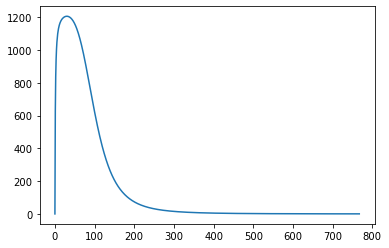

In [8]:
plt.plot (ell_0256 , cl_test_0256)

Text(0, 0.5, 'Dl')

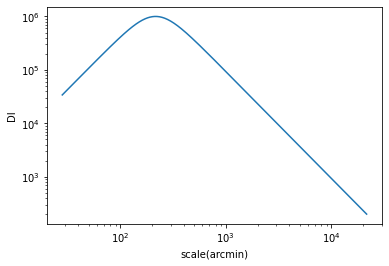

In [9]:
plt.loglog (ellsc_0256 , dl_test_0256)
plt.xlabel("scale(arcmin)")
plt.ylabel("Dl")

In [10]:
map_test_0256 = hp.synfast (cl_test_0256 , nside_0256)

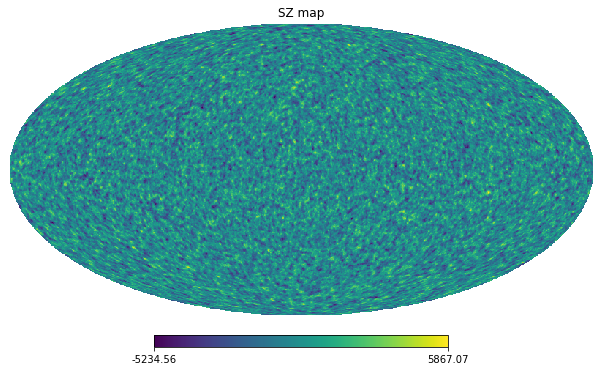

In [11]:
hp.mollview(map_test_0256 ,title="SZ map")

In [143]:
alm_test = hp.map2alm (map_test_0256)
almsize = alm_test.shape[0]
mapsize = map_test_0256.shape[0]

In [12]:
def gabor(freq,sigma,theta):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=2*np.pi*sigma*sigma
    return g


def morlet (f, sigma, theta, lmax):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=hp.beam2bl(wv,theta,lmax)[0]/hp.beam2bl(wvm,theta,lmax)[0]
    mor=wv-B*wvm
    return mor


def morlet_arr (resol, jmax, lmax, theta_bin) :
    morl=[]
    fl2beam=[]
    
    theta=np.linspace(0,np.pi,theta_bin)
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        morf = morlet (freq1, sigma1, theta, lmax)
        mor_l = hp.beam2bl(morf.real, theta, lmax)
        
        morl.append(mor_l)
    
    return morl


def gaus_arr (resol, jmax, lmax, theta_bin):
    
    theta = np.linspace(0 , np.pi , theta_bin)    
    
    phifilter=[]
    
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1 = (3.0*np.pi) / (4.0*resol*2**j)
        
        phi1 = gabor(0 , sigma1 , theta)
        gab_l = hp.gauss_beam (2 * np.sqrt (2*np.log(2)) * sigma1 ,lmax)
        #gab_lb=hp.beam2bl(phi1.real,theta,lmax=lmax)
        
        phifilter.append(gab_l)
        
    return phifilter


In [375]:
theta_bin = 10000
jmax = 9

In [376]:
res_0256 = hp.nside2resol (nside_0256 , arcmin = False)
res_0256_arcmin = hp.nside2resol (nside_0256 , arcmin = True)
res_1024 = hp.nside2resol (nside_1024 , arcmin = False)
res_1024_arcmin = hp.nside2resol (nside_1024 , arcmin = True)
res_2048 = hp.nside2resol (nside_2048 , arcmin = False)
res_2048_arcmin = hp.nside2resol (nside_2048 , arcmin = True)

In [377]:
morlet_l_arr = morlet_arr(res_0256 , jmax , lmax_0256 , theta_bin)

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


In [378]:
pix0 = hp.ang2pix (nside=nside_0256 , theta=0 , phi=0 )
Tmap = np.zeros(mapsize)
Tmap [0] = 1

In [379]:
almTmap = hp.map2alm (Tmap)
print(almTmap)

[5.18137542e-06+0.00000000e+00j 8.97514384e-06+0.00000000e+00j
 1.15857044e-05+0.00000000e+00j ... 3.15201188e-23+3.17652594e-23j
 1.54059908e-23+2.55129046e-23j 9.12663402e-24-9.10704303e-23j]


In [380]:
#almTmap = hp.map2alm (Tmap)
almTmap = np.zeros(almsize,dtype=np.complex_)
almTmap[:] = 1+0j
i1_norm = []
for j in range (jmax ):
    alm_beam = hp.almxfl(almTmap , morlet_l_arr [j])
    map_mu1 = hp.alm2map (alm_beam , nside=nside_0256)
    i1_norm.append (np.abs (map_mu1))

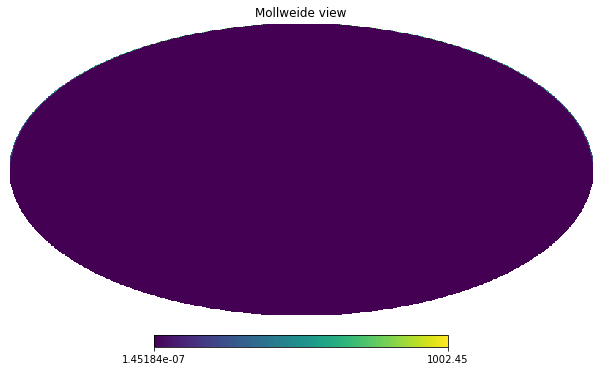

In [381]:

hp.mollview (i1_norm[1] )

In [382]:
theta_arr = np.linspace (0 , np.pi, theta_bin)

In [383]:
S1_test , i1_test = ST.compS1 (map_test_0256 , morlet_l_arr , jmax, nside_0256)

0
1
2
3
4
5
6
7
8


In [384]:
S2_test  , i2_test = ST.compS2 (i1_test , morlet_l_arr , jmax, nside_0256)

0
1
2
3
4
5
6
7
8


In [385]:
integral_size = res_0256**2* map_test_0256.shape[0]

In [386]:
S0 =  res_0256**2*np.sum (map_test_0256)
print(S0)

0.004836781971126788


In [387]:
S0_norm = (4*np.pi)

In [388]:
S0_normalized = S0/S0_norm

In [389]:
S1_norm = [np.mean (i1_norm[i]) for i in range (jmax)]
S1_norm = np.copy (S1_norm)

In [390]:
S2_norm = np.zeros ((jmax,jmax))
for j1 in range (jmax):
    mor = i1_norm[j1]
    mor_l = hp.map2alm(mor ,lmax_0256)
    for j2 in range (jmax):
        f_l = hp.almxfl (mor_l , morlet_l_arr[j2])
        f = hp.alm2map (f_l , nside=nside_0256)
        f_abs = np.abs(f)
        S2_norm[j1,j2] = np.mean (f_abs)
        
        

In [391]:
S2_normalized = S2_test/S2_norm
S1_normalized = S1_test/S1_norm

In [392]:
S1_normalized

array([  9.6921584 ,  55.42697012, 136.83495337, 210.29808386,
       188.54479691, 132.66636787,  96.3671582 ,  57.41539875,
        37.88566774])

In [393]:
I0sqrt = (res_0256**2) * np.sum (map_test_0256**2)/(S0_norm**2)
print (I0sqrt)

123080.1910334302


In [394]:
S2_sum = 0
for i in range (jmax):
    for j in range (i+1 , jmax):
        S2_sum+=S2_normalized[i,j]**2

In [395]:
S0**2+np.sum (S1_normalized**2)+S2_sum

147912.565912826

In [397]:
I1sqrt = res_0256**2 * np.sum (i1_test[0]**2)/(S0_norm)**2
I1sqrt

238.83731275108357

In [402]:
S1_normalized[0]**2+np.sum(S2_normalized[0,1:]**2)

393.9096436350552